*FileName* : Group normalization  
*Test accuracy* : (70.24%)  
*Train accuracy* : (69.19%)  
*Total params* : 45,472

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
%cd '/content/gdrive/MyDrive/ERA2/session8/'
import model

/content/gdrive/MyDrive/ERA2/session8


In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
data = train.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


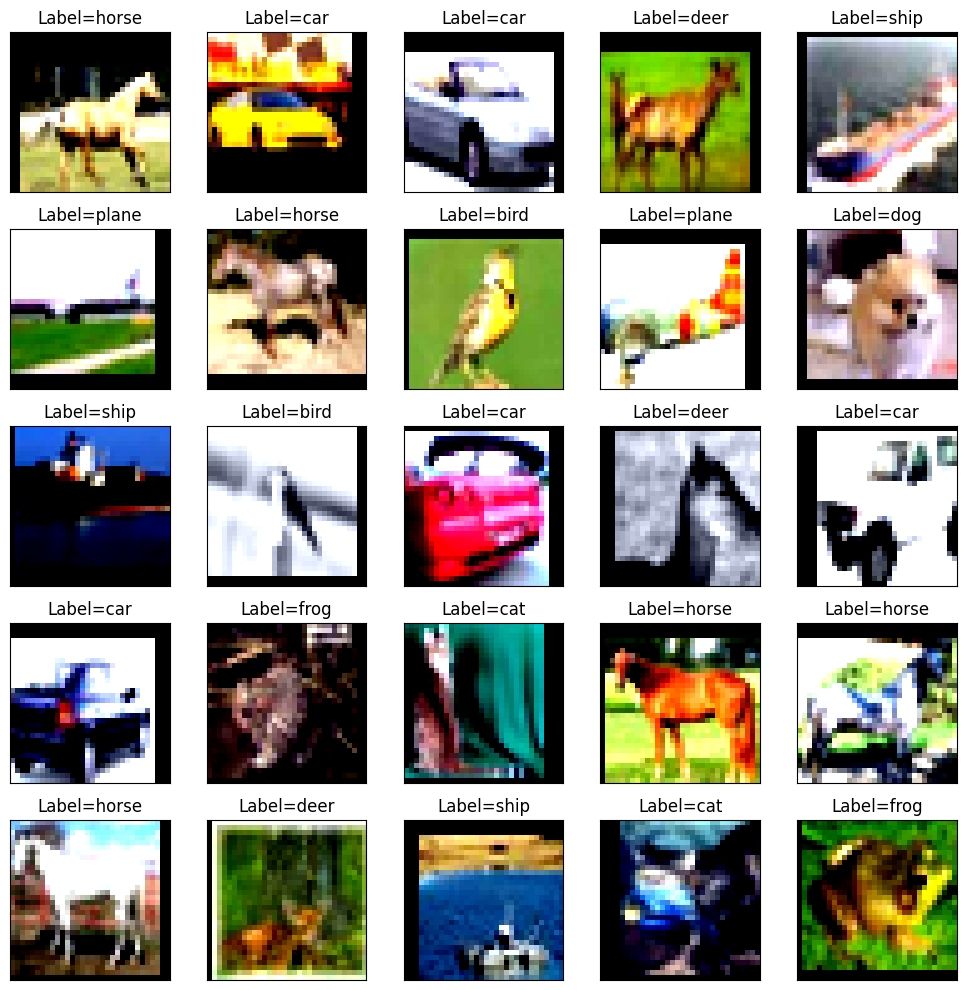

In [10]:
# get some random training images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images,labels = next(iter(train_loader))

sample_size=25

images = images[0:sample_size]
labels = labels[0:sample_size]

fig = plt.figure(figsize=(10, 10))

# Show images
for idx in np.arange(len(labels.numpy())):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    # npimg = unnormalize(images[idx])
    # ax.imshow(images[idx], cmap='gray')
    img = images[idx]/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    ax.set_title("Label={}".format(str(classes[labels[idx]])))

fig.tight_layout()
plt.show()

In [15]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_S8_GN = model.Model_S8_GN().to(device)
summary(model_S8_GN, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         GroupNorm-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 20, 30, 30]           2,880
              ReLU-6           [-1, 20, 30, 30]               0
         GroupNorm-7           [-1, 20, 30, 30]              40
           Dropout-8           [-1, 20, 30, 30]               0
            Conv2d-9           [-1, 10, 30, 30]             200
        MaxPool2d-10           [-1, 10, 15, 15]               0
           Conv2d-11           [-1, 16, 13, 13]           1,440
             ReLU-12           [-1, 16, 13, 13]               0
        GroupNorm-13           [-1, 16, 13, 13]              32
          Dropout-14           [-1

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  model.Model_S8_GN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.6530942916870117 Batch_id=390 Accuracy=32.20: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]



Test set: Average loss: 1.5673, Accuracy: 4249/10000 (42.49%)

EPOCH: 1


Loss=1.5031027793884277 Batch_id=390 Accuracy=45.09: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]



Test set: Average loss: 1.3498, Accuracy: 5073/10000 (50.73%)

EPOCH: 2


Loss=1.4493588209152222 Batch_id=390 Accuracy=51.27: 100%|██████████| 391/391 [00:24<00:00, 16.12it/s]



Test set: Average loss: 1.2265, Accuracy: 5618/10000 (56.18%)

EPOCH: 3


Loss=1.2358026504516602 Batch_id=390 Accuracy=54.86: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s]



Test set: Average loss: 1.1306, Accuracy: 5954/10000 (59.54%)

EPOCH: 4


Loss=1.0438244342803955 Batch_id=390 Accuracy=57.00: 100%|██████████| 391/391 [00:22<00:00, 17.51it/s]



Test set: Average loss: 1.1055, Accuracy: 6043/10000 (60.43%)

EPOCH: 5


Loss=1.181505560874939 Batch_id=390 Accuracy=59.39: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s]



Test set: Average loss: 1.0949, Accuracy: 6134/10000 (61.34%)

EPOCH: 6


Loss=1.1445908546447754 Batch_id=390 Accuracy=60.93: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]



Test set: Average loss: 1.0503, Accuracy: 6249/10000 (62.49%)

EPOCH: 7


Loss=0.9945918917655945 Batch_id=390 Accuracy=62.70: 100%|██████████| 391/391 [00:25<00:00, 15.33it/s]



Test set: Average loss: 1.0103, Accuracy: 6417/10000 (64.17%)

EPOCH: 8


Loss=1.1309998035430908 Batch_id=390 Accuracy=63.38: 100%|██████████| 391/391 [00:23<00:00, 16.72it/s]



Test set: Average loss: 0.9405, Accuracy: 6666/10000 (66.66%)

EPOCH: 9


Loss=0.7427111864089966 Batch_id=390 Accuracy=66.93: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]



Test set: Average loss: 0.8781, Accuracy: 6856/10000 (68.56%)

EPOCH: 10


Loss=1.0240801572799683 Batch_id=390 Accuracy=67.24: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]



Test set: Average loss: 0.8705, Accuracy: 6891/10000 (68.91%)

EPOCH: 11


Loss=0.9246051907539368 Batch_id=390 Accuracy=67.59: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]



Test set: Average loss: 0.8669, Accuracy: 6907/10000 (69.07%)

EPOCH: 12


Loss=0.9162288904190063 Batch_id=390 Accuracy=67.82: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.8598, Accuracy: 6921/10000 (69.21%)

EPOCH: 13


Loss=1.0522829294204712 Batch_id=390 Accuracy=67.94: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]



Test set: Average loss: 0.8568, Accuracy: 6910/10000 (69.10%)

EPOCH: 14


Loss=1.0415312051773071 Batch_id=390 Accuracy=68.10: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]



Test set: Average loss: 0.8716, Accuracy: 6894/10000 (68.94%)

EPOCH: 15


Loss=0.8191040754318237 Batch_id=390 Accuracy=68.37: 100%|██████████| 391/391 [00:24<00:00, 15.79it/s]



Test set: Average loss: 0.8496, Accuracy: 6939/10000 (69.39%)

EPOCH: 16


Loss=1.0144755840301514 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]



Test set: Average loss: 0.8570, Accuracy: 6929/10000 (69.29%)

EPOCH: 17


Loss=0.9533618092536926 Batch_id=390 Accuracy=68.62: 100%|██████████| 391/391 [00:23<00:00, 16.61it/s]



Test set: Average loss: 0.8286, Accuracy: 7024/10000 (70.24%)

EPOCH: 18


Loss=0.8478134274482727 Batch_id=390 Accuracy=69.19: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s]



Test set: Average loss: 0.8380, Accuracy: 7009/10000 (70.09%)

EPOCH: 19


Loss=0.8940741419792175 Batch_id=390 Accuracy=69.03: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]



Test set: Average loss: 0.8334, Accuracy: 7007/10000 (70.07%)



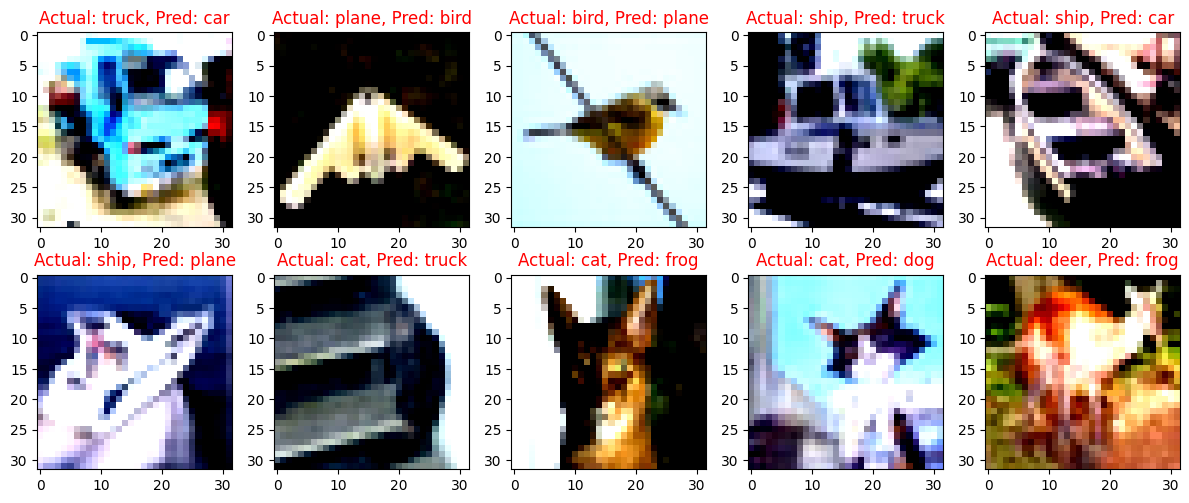

In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model.eval()

misclassified_images = []
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                actual_labels.append(classes[target[i]])
                predicted_labels.append(classes[pred[i]])

# Plot the misclassified images
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i+1)
    img = misclassified_images[i].cpu()
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, cmap='gray', interpolation='none')
    sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

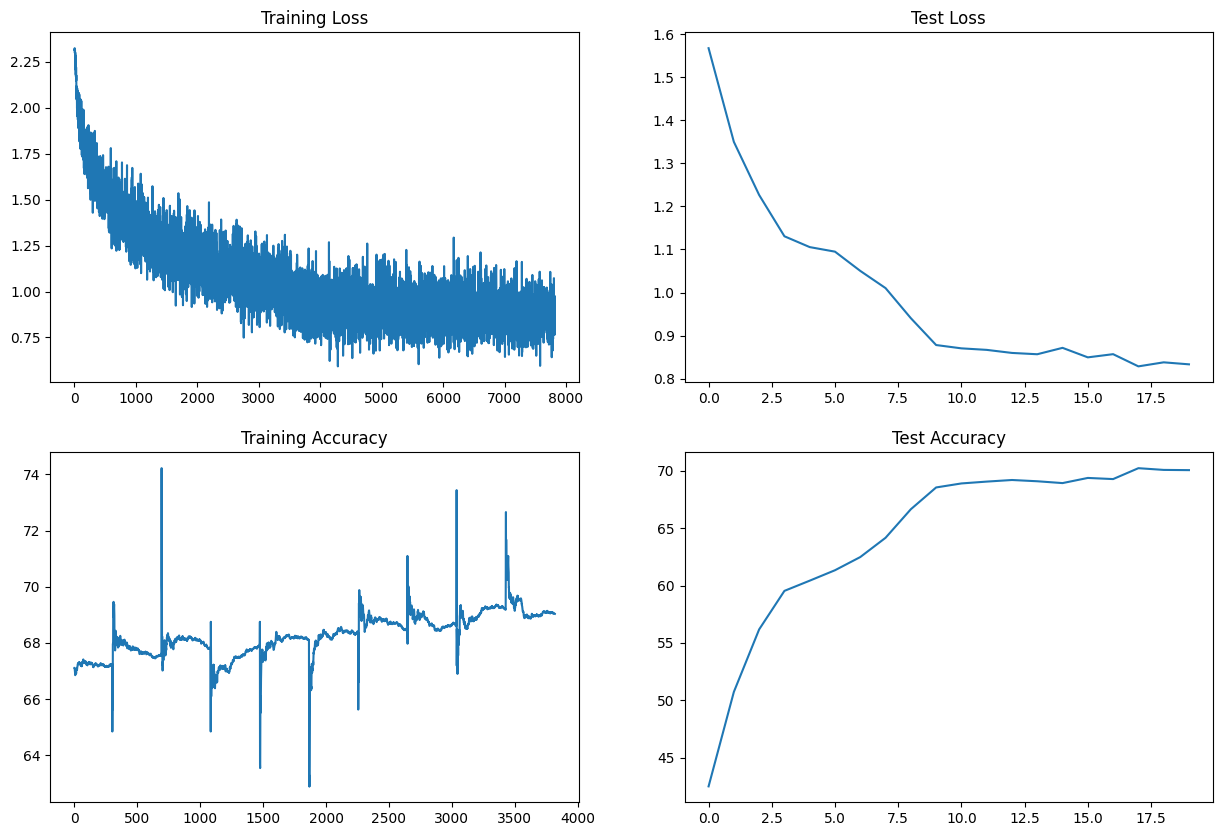

In [18]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")